In [1]:
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from geomodel import geoModel, geoDataSet, epoch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

/Users/btb/.virtualenvs/geospatial/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
batch_size = 512

dataset = geoDataSet("data/labels.npy","data/features.npy")
number_samples = len(dataset)

train_dataset, test_dataset = random_split(dataset, [round(number_samples*0.8),number_samples-round(number_samples*0.8)])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

unique_points = dataset.label_count
context_size = dataset.context_size
embedding_dimension = 10
model = geoModel(unique_points+1, embedding_dimension, context_size)

loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=.1)

In [5]:
losses = ()
for i in range(0,195):
    losses = epoch(model, loss_function, optimizer, train_dataloader, test_dataloader=test_dataloader, model_save_path="model_save/model.pt")

done | loss 10.699954 | time 1.191781(s)
epoch 54 | test loss 4.009941
loss:  1.284577 | time 0.121889(s) | Batch [    0/    9]
epoch 55 done | loss 10.621128 | time 1.256403(s)
epoch 55 | test loss 4.017828
loss:  1.181937 | time 0.108400(s) | Batch [    0/    9]
epoch 56 done | loss 10.533640 | time 1.251999(s)
epoch 56 | test loss 3.891518
loss:  1.087095 | time 0.150295(s) | Batch [    0/    9]
epoch 57 done | loss 10.460721 | time 1.246044(s)
epoch 57 | test loss 3.879580
loss:  1.076134 | time 0.113586(s) | Batch [    0/    9]
epoch 58 done | loss 10.391565 | time 1.249885(s)
epoch 58 | test loss 3.763339
loss:  1.185075 | time 0.100329(s) | Batch [    0/    9]
epoch 59 done | loss 10.316050 | time 1.199222(s)
epoch 59 | test loss 4.049163
loss:  1.091133 | time 0.115108(s) | Batch [    0/    9]
epoch 60 done | loss 10.244107 | time 1.275584(s)
epoch 60 | test loss 3.908395
loss:  1.243157 | time 0.133750(s) | Batch [    0/    9]
epoch 61 done | loss 10.168305 | time 1.263737(s)


<AxesSubplot:xlabel='Epoch', ylabel='Test Loss'>

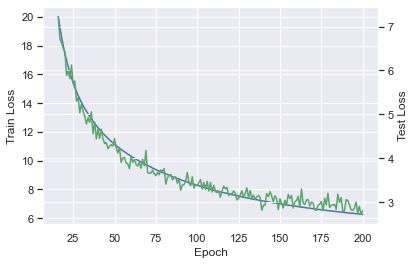

In [19]:
loss_df = pd.DataFrame({"Epoch":[i+1 for i in range(0,len(losses[0]))],"Train Loss":losses[0],"Test Loss":losses[1]})
loss_df["delta"] = loss_df["Train Loss"] - loss_df["Test Loss"]
sns.lineplot(data=loss_df[15:],x="Epoch",y="Train Loss")
ax2 = plt.twinx()
sns.lineplot(data=loss_df[15:],x="Epoch",y="Test Loss", color="g", ax=ax2)

<AxesSubplot:xlabel='Epoch', ylabel='delta'>

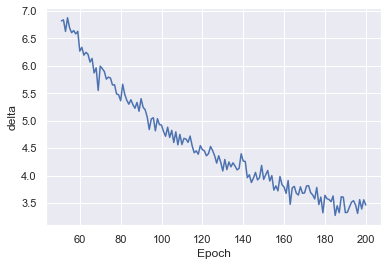

In [20]:
sns.lineplot(data=loss_df[50:],x="Epoch",y="delta")